<a href="https://colab.research.google.com/github/ChrizZhuang/marginalized_graph_kernel_protein/blob/main/Docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Mar 13 00:02:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pymatgen==2020.12.31
!pip install --pre graphdot
!pip install gdown


     |████████████████████████████████| 2.8MB 14.3MB/s 
     |████████████████████████████████| 112kB 51.9MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 27.4MB 111kB/s 
     |████████████████████████████████| 296kB 49.5MB/s 
     |████████████████████████████████| 13.2MB 252kB/s 
     |████████████████████████████████| 256kB 53.5MB/s 
     |████████████████████████████████| 552kB 50.4MB/s 
  Created wheel for pymatgen: filename=pymatgen-2020.12.31-cp37-cp37m-linux_x86_64.whl size=3590921 sha256=fa2718dae94dee414021e253578fc4e052b71fa7fe2b7288e0c7adce3c6bbbac
  Stored in directory: /root/.cache/pip/wheels/bd/fd/4c/bbea735ca0989c51e67a45d1384b1ce3481bc2aa1337b4a6e9
Successfully built pymatgen
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found exi

In [ ]:
%matplotlib inline
import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphdot
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
from graphdot.graph.reorder import rcm
from graphdot.kernel.marginalized import MarginalizedGraphKernel
from graphdot.kernel.marginalized.starting_probability import Uniform
from graphdot.model.gaussian_process import (
    GaussianProcessRegressor,
    LowRankApproximateGPR
)
from graphdot.kernel.fix import Normalization
import graphdot.microkernel as uX
import ase.io

/usr/local/lib/python3.7/dist-packages/graphdot/graph/__init__.py:24: UserWarning: Cannot import RDKit, `graph.from_rdkit()` will be unavailable.

  'Cannot import RDKit, `graph.from_rdkit()` will be unavailable.\n'


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/Google\ Colab/Covid-Data

/content/gdrive/MyDrive/Google Colab/Covid-Data


In [ ]:
files  = ['uncharged_NSP15_6W01_A_3_H.Orderable_zinc_db_enaHLL.2col.csv.1.xz']
dataset = pd.read_pickle(files[0])
#frames = [pd.read_pickle(f) for f in files]
#dataset = pd.concat(frames)

In [ ]:
dataset.head(5)

,energy,smiles,graphs
0,-2.265697,Cc1nc(no1)c2cncnc2[C@@H]3CCCN(C3)C(=O)Cc4ccccc4,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,-2.351519,Cc1ccc(cc1)c2nnc(n2N)SCC(=O)Nc3ccccc3OC,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
2,-3.308996,CCOC(=O)Cn1c2ccccc2nc1[C@H]3CC(=O)N(C3)c4ccc(c...,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
3,-3.760179,CC[C@H](C)NC(=O)[C@@H](CC)N(Cc1ccccc1)C(=O)Cc2...,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
4,-2.895577,Cc1cccc2c1ccn2CCC(=O)N3CCc4cc(c(cc4C3)OC)OC,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."


In [ ]:
target = 'energy'
N_train = 2500
N_test = 5000

In [ ]:
np.random.seed(0)
train_sel = np.random.choice(len(dataset), N_train, replace=False)
test_sel = np.random.choice(np.setxor1d(np.arange(len(dataset)), train_sel), N_test, replace=False)
train = dataset.iloc[train_sel]
test = dataset.iloc[test_sel]

In [ ]:
gpr = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-4,
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [ ]:
gpr.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|  9.2483e+06|  5.6205e+07|  9.2681e+06|      -19798|  2.2708e+07|   1.3e+02|         2|
|  7.0477e+06|  5.4659e+07|  7.0664e+06|      -18684|  2.1871e+07|   1.3e+02|       1.8|
|  4.8851e+06|  4.7042e+07|  4.9024e+06|      -17313|  2.0436e+07|   1.2e+02|       1.9|
|  4.1663e+06|  4.0942e+07|  4.1831e+06|      -16749|  1.9691e+07|   1.2e+02|       3.1|
|  3.6447e+06|  3.5014e+07|  3.6609e+06|      -16275|  1.8951e+07|   1.2e+02|       3.2|
|  3.3263e+06|  3.0755e+07|  3.3423e+06|      -15945|  1.8326e+07|   1.1e+02|       3.4|
|  3.1808e+06|  2.8965e+07|  3.1966e+06|      -15788|  1.8127e+07|   1.1e+02|       3.5|
|  3.1636e+06|  2.8096e+07|  3.1793e+06|      -15754|  1.7693e+07|   1.1e+02|       3.5|
|  3.1148e+06|  2.8068e+07|  3.1305e+06|      -15707|  1.7766e+07|   1.1e+02|       3.5|
|  3.1039e+06|  2.796

In [ ]:
gpr.kernel.hyperparameters

starting_probability : Uniform
	p : 1.0
stopping_probability : 0.00010000000000000009
node_kernel : Composite
	aromatic : Multiply
		lhs : Constant
			c : 0.020745317040533336
		rhs : KroneckerDelta
			h : 0.18431431562315057
	atomic_number : Multiply
		lhs : Constant
			c : 5.311776469014586
		rhs : KroneckerDelta
			h : 0.10000000000000002
	charge : Multiply
		lhs : Constant
			c : 0.012232607607837629
		rhs : SquareExponential
			length_scale : 1.0
	chiral : Multiply
		lhs : Constant
			c : 0.07650466922172743
		rhs : KroneckerDelta
			h : 0.11109727647636178
	hcount : Multiply
		lhs : Constant
			c : 9.948572239474858
		rhs : SquareExponential
			length_scale : 0.09935623660147404
	hybridization : Multiply
		lhs : Constant
			c : 0.026519959900936984
		rhs : KroneckerDelta
			h : 0.16554709935637946
	ring_list : Multiply
		lhs : Constant
			c : 6.569646480637104
		rhs : Convolution
			base : KroneckerDelta
				h : 0.10000000000000002
edge_kernel : Composite
	aromatic : Multiply
		l

In [ ]:
mu = gpr.predict(train.graphs)

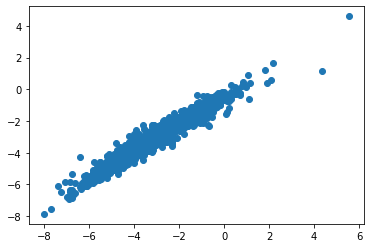

In [ ]:
plt.scatter(train[target], mu)
plt.show()

In [ ]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.20686970935482746
RMSE: 0.3186909692030075


In [ ]:
mu_test = gpr.predict(test.graphs)

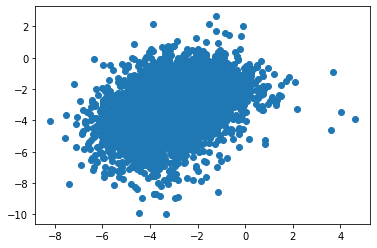

In [ ]:
plt.scatter(test[target], mu_test)
plt.show()

In [ ]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

MAE: 1.244993771620827
RMSE: 1.6025986390757625


In [ ]:
gpr2 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-2,
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [ ]:
gpr2.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|   1.667e+05|  1.9282e+05|  1.7773e+05|      -11034|  2.2742e+05|   1.3e+02|       1.9|
|  1.5585e+05|  2.2172e+05|  1.6671e+05|      -10857|  2.2218e+05|   1.3e+02|         2|
|  1.3711e+05|  2.4873e+05|  1.4755e+05|      -10447|  2.0803e+05|   1.2e+02|         2|
|  1.3286e+05|  2.3628e+05|   1.432e+05|      -10338|  2.0336e+05|   1.2e+02|       1.9|
|  1.2977e+05|  2.2742e+05|  1.4002e+05|      -10249|  1.9714e+05|   1.1e+02|         2|
|  1.3007e+05|  2.1427e+05|  1.4032e+05|      -10258|  2.0121e+05|   1.1e+02|       1.9|
|  1.2923e+05|  2.2102e+05|  1.3946e+05|      -10238|  1.9906e+05|   1.1e+02|         2|
|  1.2888e+05|  2.2097e+05|  1.3911e+05|      -10229|  1.9866e+05|   1.1e+02|       1.9|
|  1.2843e+05|  2.2339e+05|  1.3864e+05|      -10211|  1.9581e+05|   1.1e+02|         2|
|  1.2837e+05|  2.224

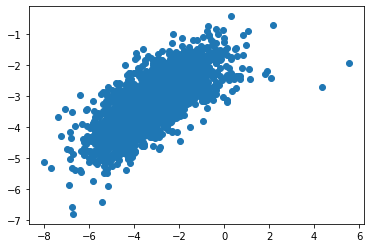

In [ ]:
mu = gpr2.predict(train.graphs)
plt.scatter(train[target], mu)
plt.show()

In [ ]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.7238574928392492
RMSE: 0.9635062924566815


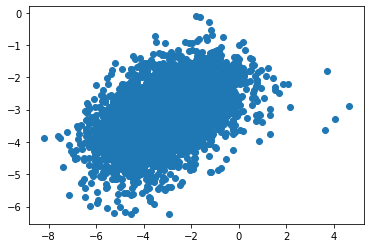

In [ ]:
mu_test = gpr2.predict(test.graphs)
plt.scatter(test[target], mu_test)
plt.show()

In [ ]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 0.9561466500156314
RMSE: 1.2284123729830978
